# Creating an Analytical Dataset
## Data Cleaning and Preparation
Udacity Business Analyst Nanodegree Project #2.1

### Import Libraries

In [22]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import Datasets

In [23]:
df_demographics = pd.read_csv('p2-wy-demographic-data.csv')
df_naics = pd.read_csv('p2-wy-453910-naics-data.csv')
df_population = pd.read_csv('p2-partially-parsed-wy-web-scrape.csv')
df_sales = pd.read_csv('p2-2010-pawdacity-monthly-sales.csv')

### Data Exploration and Cleaning

#### NAICS Market Data

In [24]:
df_naics.head()

,BUSINESS NAME,PHYSICAL CITY NAME,SALES VOLUME,CASS_LastLine
0,Mile High Mobile Pet LLC,Cheyenne,300000,"Cheyenne, WY 82007-3528"
1,Pets City Inc,Cheyenne,640000,"Cheyenne, WY 82009-4851"
2,Petco Animal Sups Stores Inc,Cheyenne,0,"Cheyenne, WY 82009-4945"
3,Pet-A-Care,Cheyenne,81000,"Cheyenne, WY 82009-1009"
4,Muddy Paws Pet Salon,Laramie,76000,"Laramie, WY 82070-8979"


#### U.S. Census Population Data

In [25]:
df_population = df_population.dropna(subset=['City|County'])
df_population['City'], df_population['County'] = df_population['City|County'].str.split('|').str
df_population['City'] = df_population['City'].apply(lambda x: x.replace('?',''))
df_population['City'] = df_population['City'].apply(lambda x: x.strip())
df_population['2014 Estimate'] = df_population['2014 Estimate'].apply(lambda x: x.split('<')[1].replace('td>','').replace(',',''))
df_population['2000 Census'] = df_population['2000 Census'].apply(lambda x: x.split('<')[1].replace('td>','').replace(',',''))
df_population['2010 Census'] = df_population['2010 Census'].apply(lambda x: x.split('<')[1].replace('td>','').replace(',',''))
df_population = df_population[['City', 'County', '2000 Census', '2010 Census', '2014 Estimate']]
df_population = df_population.set_index(['City', 'County'])
df_population.head()

,,2000 Census,2010 Census,2014 Estimate
City,County,,,
Afton,Lincoln,1818,1911,1968
Albin,Laramie,120,181,185
Alpine,Lincoln,550,828,845
Baggs,Carbon,348,440,439
Bairoil,Sweetwater,97,106,107


#### Wyoming Demographics Data by City/County w/ Population Join

In [26]:
df_demographics = df_demographics.set_index(['City', 'County'])
df_demographics = df_demographics.join(df_population, how='inner')
df_demographics = df_demographics.reset_index().set_index('City')
df_demographics.head()

,County,Land Area,Households with Under 18,Population Density,Total Families,2000 Census,2010 Census,2014 Estimate
City,,,,,,,,
Afton,Lincoln,853.806650,497,0.93,1040.41,1818,1911,1968
Albin,Laramie,7.685902,37,0.10,74.87,120,181,185
Alpine,Lincoln,366.598892,213,0.40,446.72,550,828,845
Baggs,Carbon,253.240322,62,0.06,129.53,348,440,439
Bairoil,Sweetwater,29.459830,18,0.01,33.70,97,106,107


#### Pawdacity 2010 Sales Data by Month

In [27]:
df_sales['August'] = df_sales.pop('August ')
df_sales.head()

,NAME,ADDRESS,CITY,STATE,ZIP,January,February,March,April,May,June,July,August,September,October,November,December
0,Pawdacity,509 Fort St # A,Buffalo,WY,82834,16200,13392,14688,17064,18360,14040,12960,19224,15984,13392,13176,16848
1,Pawdacity,601 SE Wyoming Blvd Unit 252,Casper,WY,82609,29160,21600,27000,27648,29160,27216,25488,25704,22896,25272,28944,27648
2,Pawdacity,1400 Dell Range Blvd,Cheyenne,WY,82009,47520,44280,47088,46656,43200,45144,44064,45360,47736,42984,44712,47304
3,Pawdacity,3769 E Lincolnway,Cheyenne,WY,82001,32400,26352,31968,30888,30456,32832,29808,32184,30780,31536,30024,32616
4,Pawdacity,2625 Big Horn Ave,Cody,WY,82414,19440,15984,19008,18144,16632,17496,18792,20304,19224,18144,18576,16632


### Data Blending / Preparation

In [28]:
# Group sales by city
groupby_city = df_sales.groupby(by='CITY')
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
df_sales_by_city = \
    groupby_city[months].agg('sum')

In [29]:
# Blend demographics/population and sales dataframes to create training dataframe
df_train = df_sales_by_city.join(df_demographics)
df_train['Total Sales'] = df_train[months].sum(axis=1)
df_train.drop(months + ['2000 Census', '2014 Estimate', 'County'], axis=1, inplace=True)
df_train['2010 Census Population'] = df_train.pop('2010 Census')
df_train = df_train.apply(lambda x: x.apply(float))
# Rearrange Columns
df_train = df_train[['2010 Census Population', 'Total Sales',
                     'Households with Under 18', 'Land Area',
                     'Population Density', 'Total Families']]

# Print sum of each feature
df_train.sum()

2010 Census Population      2.138620e+05
Total Sales                 3.773304e+06
Households with Under 18    3.406400e+04
Land Area                   3.307138e+04
Population Density          6.280000e+01
Total Families              6.265279e+04
dtype: float64

In [30]:
df_train_all = df_train.append(pd.DataFrame(df_train.sum(), columns=['TOTAL']).T)
df_train_all = df_train_all.append(pd.DataFrame(df_train.mean(), columns=['AVERAGE']).T)
df_train_all

,2010 Census Population,Total Sales,Households with Under 18,Land Area,Population Density,Total Families
Buffalo,4585.0,1.853280e+05,746.000000,3115.507500,1.550000,1819.500000
Casper,35316.0,3.177360e+05,7788.000000,3894.309100,11.160000,8756.320000
Cheyenne,59466.0,9.178920e+05,7158.000000,1500.178400,20.340000,14612.640000
Cody,9520.0,2.183760e+05,1403.000000,2998.956960,1.820000,3515.620000
Douglas,6120.0,2.080080e+05,832.000000,1829.465100,1.460000,1744.080000
Evanston,12359.0,2.838240e+05,1486.000000,999.497100,4.950000,2712.640000
Gillette,29087.0,5.431320e+05,4052.000000,2748.852900,5.800000,7189.430000
Powell,6314.0,2.339280e+05,1251.000000,2673.574550,1.620000,3134.180000
Riverton,10615.0,3.032640e+05,2680.000000,4796.859815,2.340000,5556.490000
Rock Springs,23036.0,2.535840e+05,4022.000000,6620.201916,2.780000,7572.180000


### Outlier Detection

In [31]:
IQR = df_train.quantile(q=0.75)-df_train.quantile(q=0.25)
Upper_Fence = df_train.quantile(q=0.75) + 1.5*IQR
Lower_Fence = df_train.quantile(q=0.25) - 1.5*IQR

for row, value in df_train.iterrows():
#     print(row)
    for key in value.keys():
        if value[key] > Upper_Fence[key]:
            print(key + ' exceeds upper fence in ' + row)
        elif value[key] < Lower_Fence[key]:
            print(key + ' exceeds lower fence in ' + row)

2010 Census Population exceeds upper fence in Cheyenne
Total Sales exceeds upper fence in Cheyenne
Population Density exceeds upper fence in Cheyenne
Total Families exceeds upper fence in Cheyenne
Total Sales exceeds upper fence in Gillette
Land Area exceeds upper fence in Rock Springs


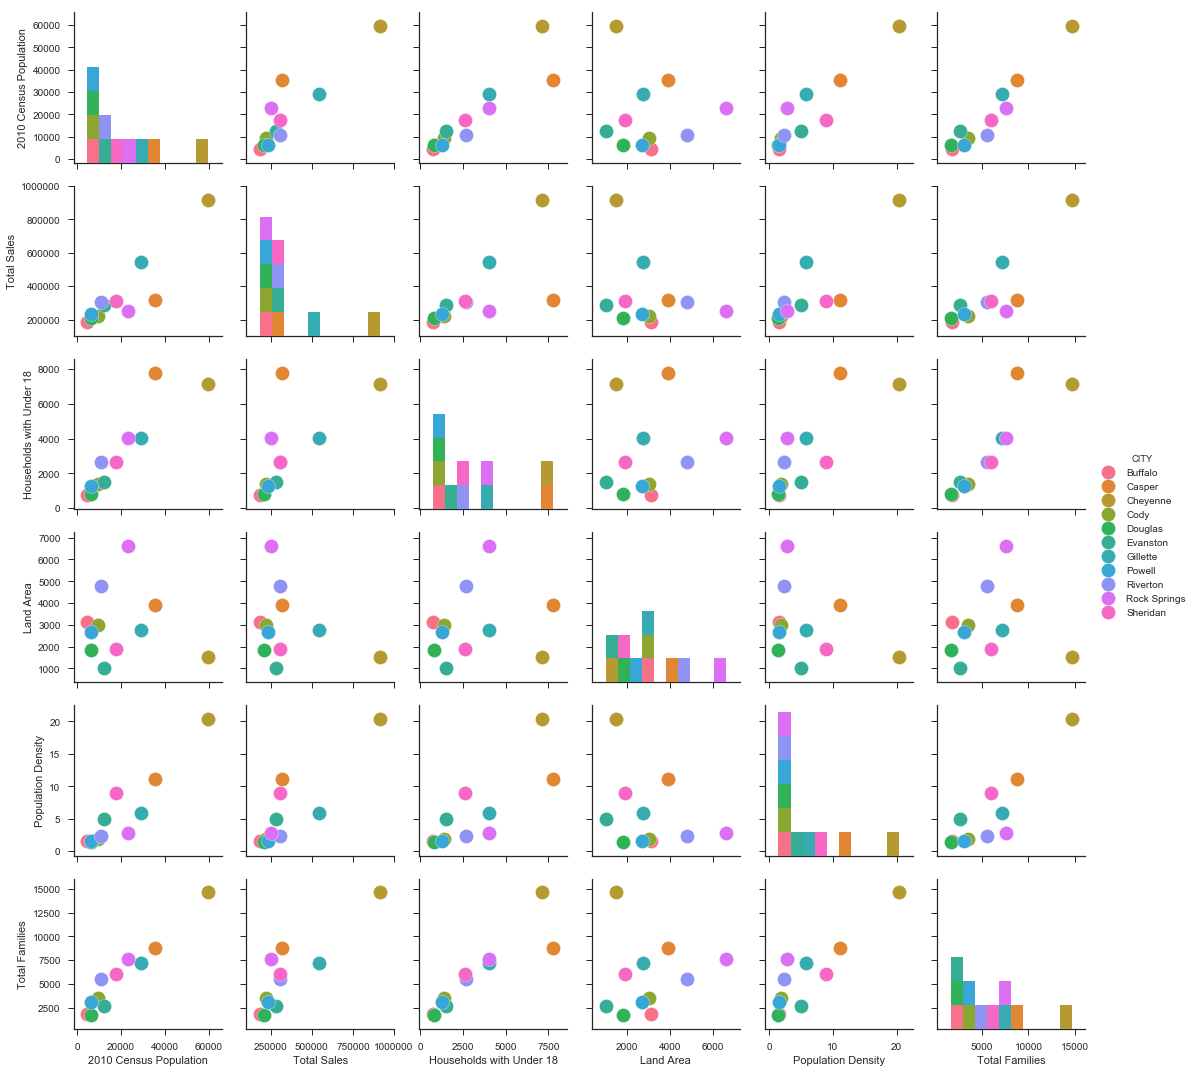

In [32]:
sns.pairplot(df_train.reset_index(), hue='CITY', plot_kws={'s': 200})

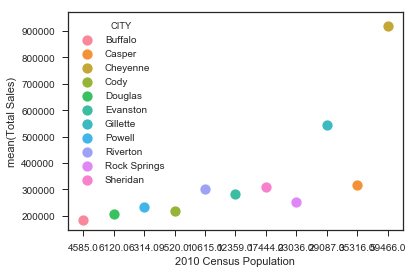

In [47]:
# sns.regplot(data=df_train.reset_index(), x='Land Area', y='Total Sales')
sns.pointplot(data=df_train.reset_index(), x='2010 Census Population', y='Total Sales', hue='CITY')

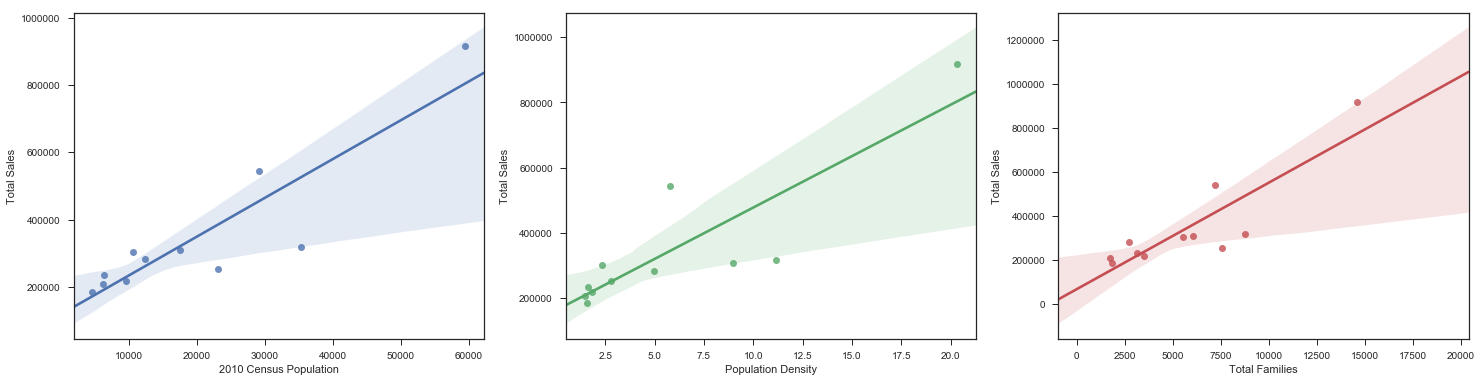

In [45]:
sns.set_style('ticks')
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,6))
sns.regplot(data=df_train, x='2010 Census Population', y='Total Sales', ax=ax1)
sns.regplot(data=df_train, x='Population Density', y='Total Sales', ax=ax2)
sns.regplot(data=df_train, x='Total Families', y='Total Sales', ax=ax3)